# IMU Random Motion Dataset - Demo Notebook

This notebook shows how to:
1. Load and visualize the IMU data for a specific dataset sample
2. Convert the IMU data between various 3D rotation representations
3. Query the dataset based on specific metadata

In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import numpy.typing as npt
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Video
from scipy.spatial.transform import Rotation

plt.style.use("seaborn-deep")

**Helper Methods**

In [2]:
rotation_matrix_labels = [
        "rotation_matrix_m11",
        "rotation_matrix_m12",
        "rotation_matrix_m13",
        "rotation_matrix_m21",
        "rotation_matrix_m22",
        "rotation_matrix_m23",
        "rotation_matrix_m31",
        "rotation_matrix_m32",
        "rotation_matrix_m33",
    ]

def load_rotation_matrices_from_path(data_path: str) -> npt.NDArray[np.float64]:
    """Loads rotation matrices from a dataset csv file."""
    imu_data = pd.read_csv(data_path)
    return imu_data[rotation_matrix_labels].values.reshape(-1, 3, 3)

def plot_rotation_matrices(rotation_matrices: npt.NDArray[np.float64]):
    """Plots rotation matrices associated with a dataset sample."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 2), dpi = 200)
    ax.plot(rotation_matrices.reshape(-1, 9), label = [rm.split("_")[-1] for rm in rotation_matrix_labels])
    ax.set_title("Rotation Matrices")
    plt.legend(loc = "center right")
    plt.tight_layout()
    plt.show()

## Demo 1: Loading and visualizing a single dataset sample

We have added a single example from the dataset to this repo (`./sample_data`). Here, we demonstrate how to load and visualize the rotation matrices. 

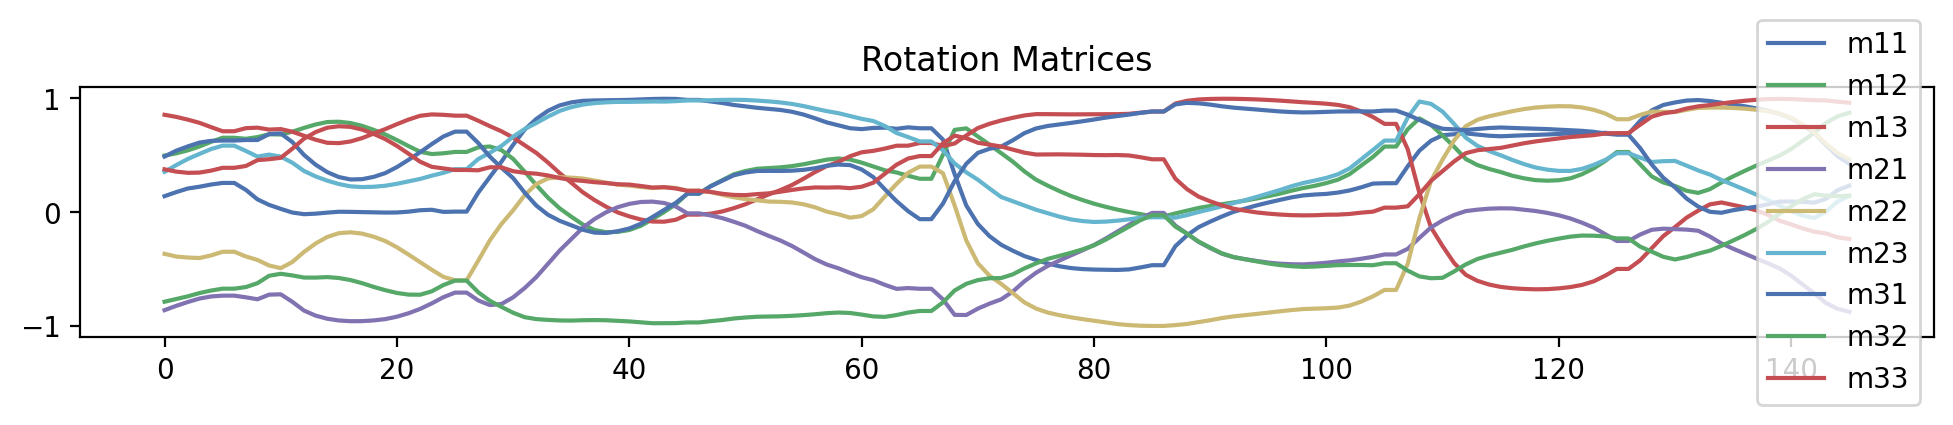

In [3]:
# load the rotation matrices.
rotation_matrices = load_rotation_matrices_from_path("sample_data/00000.csv")

# plot the rotation matrices.
plot_rotation_matrices(rotation_matrices)

## Demo 2: Conversion to Quaternions & Eulers

The IMU Random Motion Dataset represents angular position using rotation matrices. Here, we show how rotation matrices can be easily converted to quaternions or eulers using `scipy`.

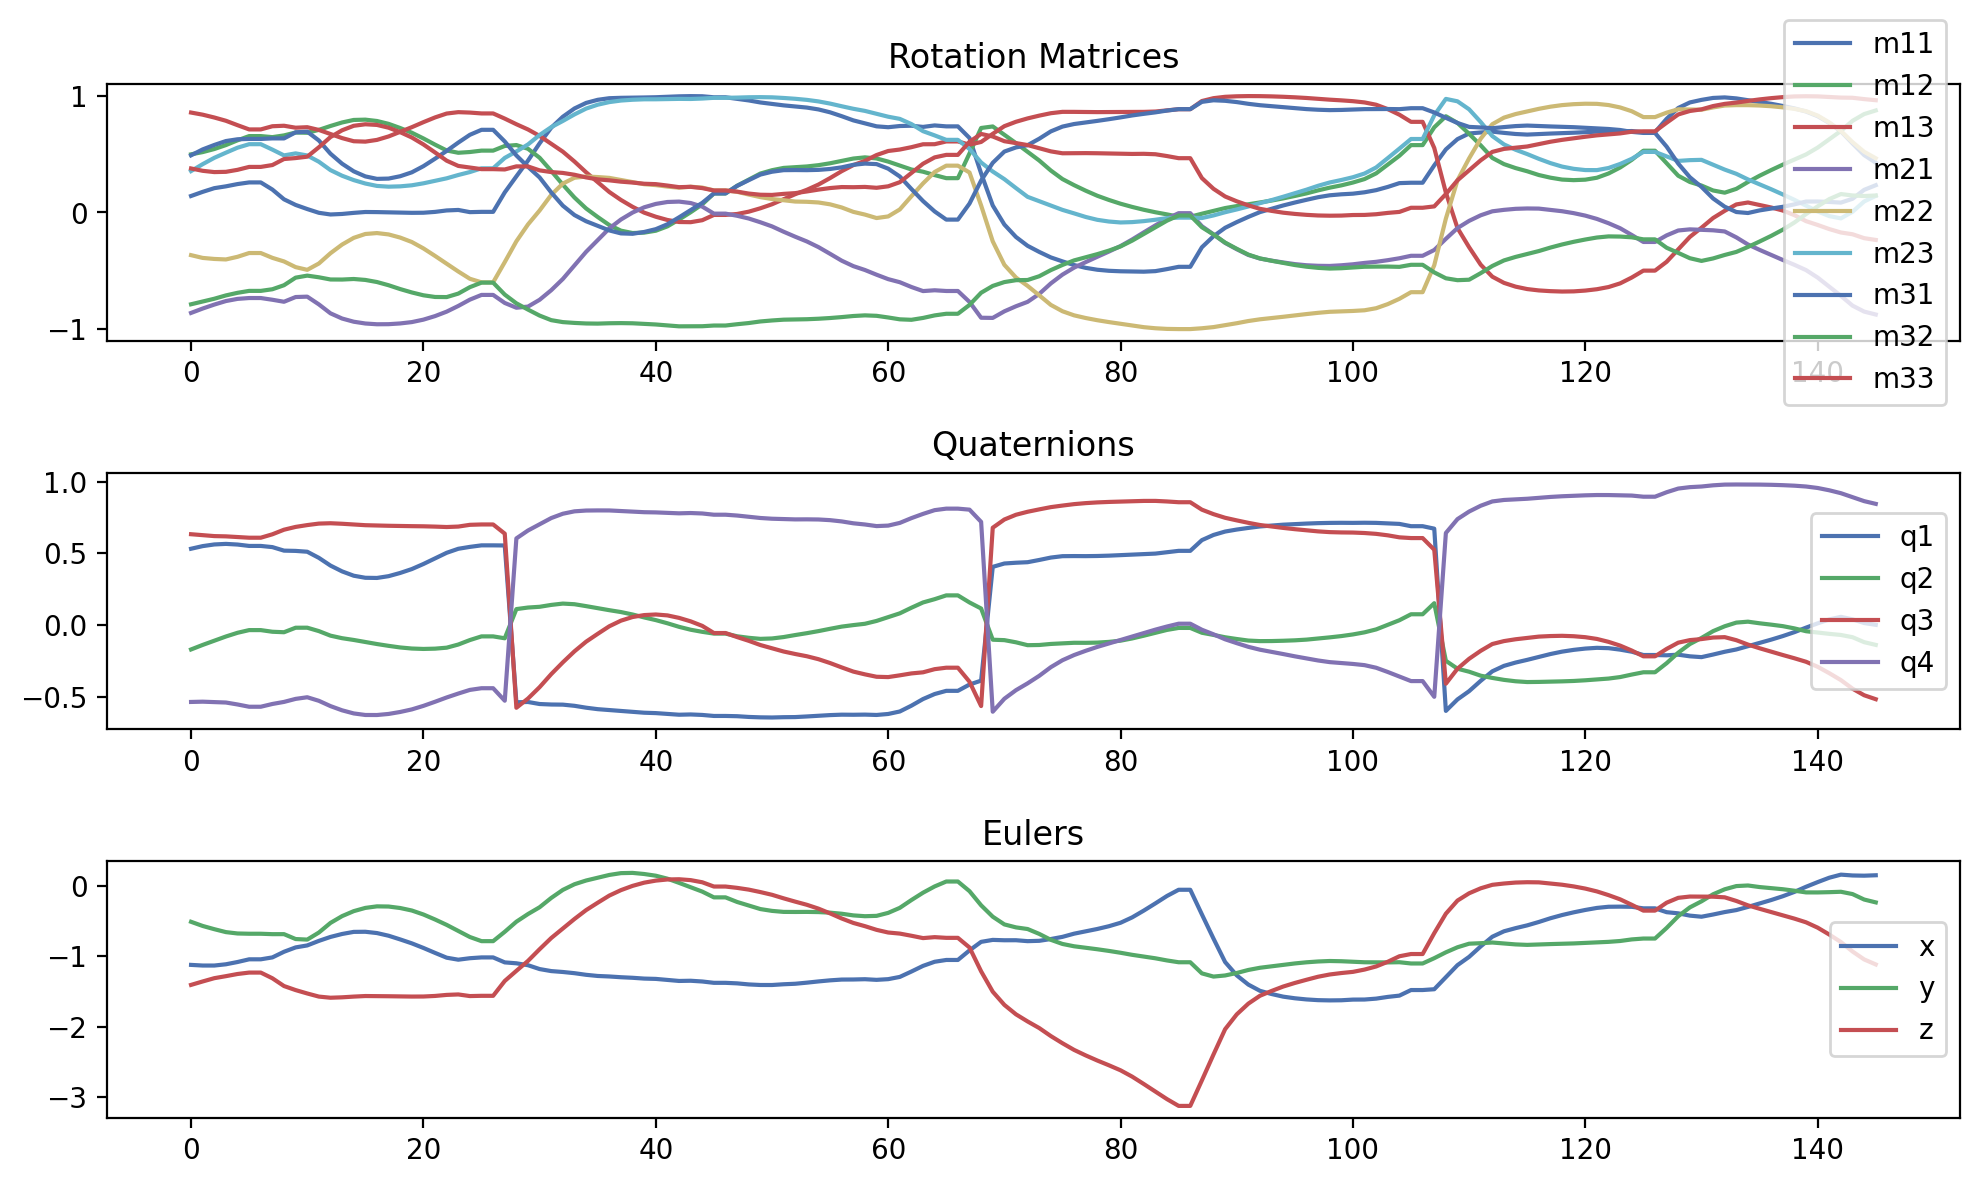

In [4]:
# convert rotation matrices to quaternions.
quaternions = Rotation.from_matrix(rotation_matrices).as_quat()

# convert rotation matrices to eulers.
eulers = Rotation.from_matrix(rotation_matrices).as_euler("xyz")

# plot rotation matrix, quaternion, and euler representations.
fig, ax = plt.subplots(3, 1, figsize=(10, 6), dpi=200)

ax[0].set_title("Rotation Matrices")
ax[0].plot(rotation_matrices.reshape(-1, 9), label=[rm.split("_")[-1] for rm in rotation_matrix_labels]);
ax[0].legend(loc="center right")

ax[1].set_title("Quaternions")
ax[1].plot(quaternions, label=["q1", "q2", "q3", "q4"]);
ax[1].legend()
ax[1].legend(loc="center right")

ax[2].set_title("Eulers")
ax[2].plot(eulers, label=["x", "y", "z"]);
ax[2].legend()
ax[2].legend(loc="center right")

plt.tight_layout()
plt.show()

## Demo 3: Querying samples from the dataset based on provided metadata

The IMU Random Motion dataset contains 400 random motion samples with a wide variety of parameters.Here, we show how this metadata can be organized into an easily queryable dataframe using `pandas`. 

In [5]:
PATH_TO_IMU_RANDOM_FOLDER = "PATH_TO_RANDOM_FOLDER"

In [6]:
all_param_paths = glob.glob(PATH_TO_IMU_RANDOM_FOLDER + "/*_params.json")

metadata = []
for param_path in all_param_paths:
    metadata_dict = {}
    metadata_dict["pid"] = Path(param_path).name.split("_")[0]
    parameters = json.load(open(param_path))["params"]
    metadata_dict.update(parameters)
    metadata_dict["imu_path"] = param_path.replace("_params.json", ".csv")
    metadata_dict["video_path"] = param_path.replace("_params.json", ".mp4")
    metadata_dict["parameter_path"] = param_path
    metadata.append(metadata_dict)

metadata = pd.DataFrame(metadata).sort_values(by="pid")
metadata.head()

,pid,wrist_offset_deg,ref_xy_rotation,watch_location,crown_orientation,randomize_body_shape,use_random_motion,frames_per_second,image_width,image_height,num_random_frames,imu_path,video_path,parameter_path
344,00000,-4.612476,0.415877,LEFT,LEFT,True,True,20,480,480,146,/tmp/data2/00000.csv,/tmp/data2/00000.mp4,/tmp/data2/00000_params.json
150,00001,12.719877,1.937988,LEFT,RIGHT,True,True,20,480,480,220,/tmp/data2/00001.csv,/tmp/data2/00001.mp4,/tmp/data2/00001_params.json
46,00002,4.988222,2.959430,LEFT,RIGHT,True,True,20,480,480,245,/tmp/data2/00002.csv,/tmp/data2/00002.mp4,/tmp/data2/00002_params.json
258,00003,3.038999,2.208523,RIGHT,LEFT,True,True,20,480,480,168,/tmp/data2/00003.csv,/tmp/data2/00003.mp4,/tmp/data2/00003_params.json
135,00004,-2.155002,2.770360,RIGHT,LEFT,True,True,20,480,480,204,/tmp/data2/00004.csv,/tmp/data2/00004.mp4,/tmp/data2/00004_params.json


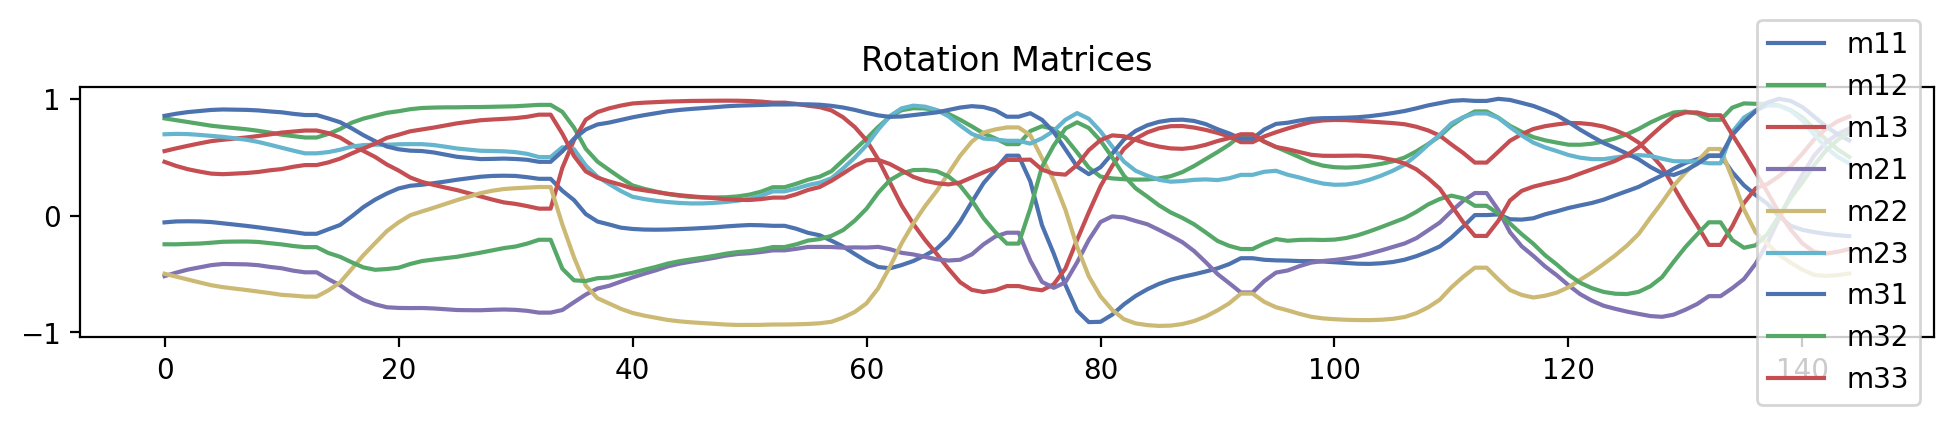

In [7]:
# select any row in metadata.
sample = metadata.query("watch_location == 'LEFT'").sample(1).squeeze()

# load the rotation matrices.
rotation_matrices = load_rotation_matrices_from_path(sample.imu_path)

# plot the rotation matrices.
plot_rotation_matrices(rotation_matrices)